# Lesson26

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

class Network(nn.Module):#line 1
    def __init__(self):
        super(Network,self).__init__()# line 3
        #第一层的输入为1，参数依赖数据集（用的是单色图像）
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        
        
        self.fc1 = nn.Linear(in_features=12*4*4,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=60) 
        self.out = nn.Linear(in_features=60,out_features=10)
        #最后一层输出为10，分类有10个类别，也依赖数据集
    def forward(self,t):  
        #(1) input layer
        t = t 
        
        #(2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2,stride=2)
        
         #(3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2,stride=2)
        
        #(4)hidden liner layer
        t = t.reshape(-1,12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        
        #(5)hidden liner layer
        t = self.fc2(t)
        t = F.relu(t)
        
        #(6) outpur layer
        t = self.out(t)
        #t = F.softmax(t,dim=1)
        
        return t

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.5.0
0.6.0


In [3]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [4]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST'
    ,train = True
    ,download = True
    ,transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

In [12]:
network = Network()
train_loader = torch.utils.data.DataLoader(train_set,batch_size=100)
optimizer = optim.Adam(network.parameters(),lr=0.01)

for epoch in range(10):

    total_loss=0
    total_correct=0

    for batch in train_loader:#get batch
        images,labels = batch

        preds = network(images)#pass batch
        loss = F.cross_entropy(preds,labels)#calculate loss

        optimizer.zero_grad()
        loss.backward()#calculate gradients
        optimizer.step()#update weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds,labels)

    print("epoch:",epoch,"total_correct:",total_correct,"loss:",total_loss)

epoch: 0 total_correct: 46465 loss: 352.5322376489639
epoch: 1 total_correct: 51132 loss: 238.34188690781593
epoch: 2 total_correct: 51971 loss: 217.58019244670868
epoch: 3 total_correct: 52339 loss: 207.82903580367565
epoch: 4 total_correct: 52587 loss: 199.84469735622406
epoch: 5 total_correct: 52643 loss: 199.2980579584837
epoch: 6 total_correct: 52658 loss: 197.71342447400093
epoch: 7 total_correct: 52834 loss: 195.12700966000557
epoch: 8 total_correct: 52955 loss: 190.34085263311863
epoch: 9 total_correct: 52940 loss: 192.23344638943672


In [13]:
total_correct / len(train_set)

0.8823333333333333

# Lesson27

## Analyzing CNN Results - Building and Plotting a Confusing Matrix
看网络在哪里预测错了

In [14]:
len(train_set)

60000

In [16]:
len(train_set.targets)

60000

## getting prdictions for  the entire training set 

In [17]:
def get_all_preds(model,loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images,labels = batch
        
        preds = model(images)
        all_preds = torch.cat(
            (all_preds,preds)
        ,dim=0
        )
    return all_preds

In [19]:
prediction_loader = torch.utils.data.DataLoader(train_set,batch_size=10000)
train_preds = get_all_preds(network,prediction_loader)

In [21]:
train_preds.shape

torch.Size([60000, 10])

In [22]:
print(train_preds.requires_grad)

True


In [23]:
train_preds.grad

C:\Users\user\.conda\envs\torch\lib\site-packages\torch\tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "


In [24]:
train_preds.grad_fn

In [25]:
#取消跟踪梯度
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set,batch_size=10000)
    train_preds = get_all_preds(network,prediction_loader)

In [26]:
print(train_preds.requires_grad)

False


In [27]:
train_preds.grad

In [28]:
train_preds.grad_fn

In [31]:
preds_correct = get_num_correct(train_preds,train_set.targets)

print('total correct:',preds_correct)
print('accuracy:',preds_correct / len(train_set))

total correct: 52775
accuracy: 0.8795833333333334


## building a confusion matrix

In [32]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [33]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

In [34]:
stacks = torch.stack(
    (
        train_set.targets
        ,train_preds.argmax(dim=1)
    )
    ,dim=1
)

In [35]:
stacks.shape

torch.Size([60000, 2])

In [36]:
stacks

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [41]:
stacks[0].tolist()

[9, 9]

In [38]:
cmt = torch.zeros(10,10,dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [39]:
for p in stacks:
    j,k = p.tolist()
    cmt[j,k] = cmt[j,k] + 1

In [40]:
cmt

tensor([[5227,   30,   93,  133,   17,   17,  444,    2,   37,    0],
        [  13, 5896,   12,   59,    8,    4,    2,    0,    5,    1],
        [  60,    1, 4689,   63,  755,    0,  397,    2,   33,    0],
        [ 184,  209,   27, 5213,  218,   19,  115,    2,    7,    6],
        [  17,   11,  307,  182, 4898,    3,  563,    0,   17,    2],
        [   0,    2,    0,    0,    0, 5778,    2,  122,    1,   95],
        [1075,   18,  602,  174,  300,    6, 3727,    0,   97,    1],
        [   0,    0,    0,    0,    0,   80,    1, 5775,    1,  143],
        [  15,    2,   22,   11,   30,   52,   26,   11, 5826,    5],
        [   0,    0,    0,    0,    0,   27,    0,  225,    2, 5746]])

## Plotting a confusing matrix 

In [46]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix

In [48]:
cm = confusion_matrix(train_set.targets,train_preds.argmax(dim=1))
cm

array([[5227,   30,   93,  133,   17,   17,  444,    2,   37,    0],
       [  13, 5896,   12,   59,    8,    4,    2,    0,    5,    1],
       [  60,    1, 4689,   63,  755,    0,  397,    2,   33,    0],
       [ 184,  209,   27, 5213,  218,   19,  115,    2,    7,    6],
       [  17,   11,  307,  182, 4898,    3,  563,    0,   17,    2],
       [   0,    2,    0,    0,    0, 5778,    2,  122,    1,   95],
       [1075,   18,  602,  174,  300,    6, 3727,    0,   97,    1],
       [   0,    0,    0,    0,    0,   80,    1, 5775,    1,  143],
       [  15,    2,   22,   11,   30,   52,   26,   11, 5826,    5],
       [   0,    0,    0,    0,    0,   27,    0,  225,    2, 5746]],
      dtype=int64)

In [53]:
names = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [55]:
import itertools
import numpy as np

def plot_confusion_matrix(cm,classes,title='Confusion matrix',cmap=plt.cm.Blues):
    print(cm)
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    fmt = 'd'
    thresh = cm.max()/2.
    for i ,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j]> thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

[[5227   30   93  133   17   17  444    2   37    0]
 [  13 5896   12   59    8    4    2    0    5    1]
 [  60    1 4689   63  755    0  397    2   33    0]
 [ 184  209   27 5213  218   19  115    2    7    6]
 [  17   11  307  182 4898    3  563    0   17    2]
 [   0    2    0    0    0 5778    2  122    1   95]
 [1075   18  602  174  300    6 3727    0   97    1]
 [   0    0    0    0    0   80    1 5775    1  143]
 [  15    2   22   11   30   52   26   11 5826    5]
 [   0    0    0    0    0   27    0  225    2 5746]]


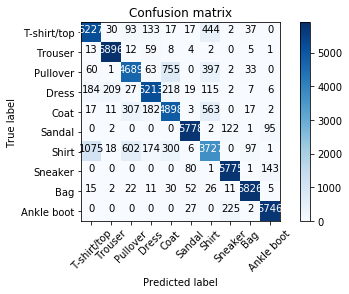

In [56]:
plot_confusion_matrix(cm,names)

# Lesson28 

## Pytorch：Stack vs Cat 

In [90]:
t1 = torch.tensor([1,1,1])
t2 = torch.tensor([2,2,2])
t3 = torch.tensor([3,3,3])

In [91]:
torch.cat((t1,t2,t3),dim=0)

tensor([1, 1, 1, 2, 2, 2, 3, 3, 3])

In [92]:
torch.stack((t1,t2,t3),dim=0)

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])

In [65]:
torch.cat((t1.unsqueeze(0),t2.unsqueeze(0),t3.unsqueeze(0)),dim=0)

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])

In [74]:
torch.stack((t1,t2,t3),dim=1)

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [93]:
torch.cat((t1.unsqueeze(1),t2.unsqueeze(1),t3.unsqueeze(1)),dim=1)

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [94]:
t1.unsqueeze(1)

tensor([[1],
        [1],
        [1]])

## numpy :Stack 

In [75]:
import numpy as np

In [78]:
t1 = np.array([1,1,1])
t2 = np.array([2,2,2])
t3 = np.array([3,3,3])

In [79]:
np.concatenate((t1,t2,t3),axis=0)

array([1, 1, 1, 2, 2, 2, 3, 3, 3])

In [80]:
np.stack((t1,t2,t3),axis=0)

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

In [81]:
np.concatenate(
    (
        np.expand_dims(t1,0),
        np.expand_dims(t2,0),
        np.expand_dims(t3,0)
    ),axis=0)

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

In [82]:
np.stack((t1,t2,t3),axis=1)

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [86]:
np.concatenate(
    (
        np.expand_dims(t1,1),
        np.expand_dims(t2,1),
        np.expand_dims(t3,1)
    ),axis=1)

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

# Lesson29 

In [95]:
from torch.utils.tensorboard import SummaryWriter

C:\Users\user\.conda\envs\torch\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\.conda\envs\torch\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\.conda\envs\torch\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\.conda\envs\torch\lib\site-packages\tensorboard\co